# Wind Downscaling

## Prerequisites

* Conda environment
* Get a Copernicus API key from: https://cds.climate.copernicus.eu/api-how-to
  * create a file at \$HOME/.cdsapirc with the required UID and key

## Install the required packages

In [1]:
import os
from datetime import date, datetime
from pathlib import Path

In [2]:
!pip uninstall downscaling -y
!pip install -U git+https://github.com/OpheliaMiralles/wind-downscaling-gan.git

Found existing installation: downscaling 1.0
Uninstalling downscaling-1.0:
  Successfully uninstalled downscaling-1.0
  Cloning https://github.com/OpheliaMiralles/WindDownscaling_EPFL_UNIBE.git to /private/var/folders/nb/drg15dgx4mj6bqb_f4c9bnvc0000gp/T/pip-req-build-bfon34j6
  Running command git clone -q https://github.com/OpheliaMiralles/WindDownscaling_EPFL_UNIBE.git /private/var/folders/nb/drg15dgx4mj6bqb_f4c9bnvc0000gp/T/pip-req-build-bfon34j6
  Created wheel for downscaling: filename=downscaling-1.0-py3-none-any.whl size=15520 sha256=693bfe144c9a5cd98f4fb65394c9ff6080e3e488d78f1e239a1c9b4922f6fc69
  Stored in directory: /private/var/folders/nb/drg15dgx4mj6bqb_f4c9bnvc0000gp/T/pip-ephem-wheel-cache-98hwjq22/wheels/9a/76/c2/86e8f27804b4255a52a51542e4b444c005536c898171d1681e
Successfully built downscaling


In [3]:
!conda install -y -c conda-forge gdal tensorflow xarray numpy=1.19.5 pandas pysftp cdsapi elevation rasterio dask python-dotenv

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.10.3
  latest version: 4.11.0

Please update conda by running

    $ conda update -n base conda



# All requested packages already installed.



In [4]:
!pip install topo-descriptors

## Set configuration

In [5]:
DATA_ROOT = Path('./data')
ERA5_DATA_FOLDER = DATA_ROOT / 'ERA5_FR'
DEM_DATA_FILE = DATA_ROOT / 'dem/France-90m-DEM.tif'
START_DATE = date(2016,4,1)
END_DATE = date(2016,4,2)
LONGITUDE_R = (-4.96, 8.3)
LATITUDE_R = (42.2, 51.3)

## Data Loading

In [6]:
from downscaling.data import download_ERA5
download_ERA5(ERA5_DATA_FOLDER, START_DATE, END_DATE, LATITUDE_R, LONGITUDE_R)
print('Done')

File 20160401_era5_surface_hourly already exists
File 20160402_era5_surface_hourly already exists
File 20160401_era5_z500_hourly already exists
File 20160402_era5_z500_hourly already exists
Done


In [7]:
if not DEM_DATA_FILE.exists():
    dest = str(DEM_DATA_FILE)
    !eio --product SRTM3 clip -o {dest} --bounds -4.96 42.2 8.3 51.3

## Downscaling

In [11]:
from downscaling import downscale, plot_wind_fields
import xarray as xr

In [9]:
era5 = xr.open_mfdataset(ERA5_DATA_FOLDER.glob('20160401*surface*.nc'))
raster_topo = xr.open_rasterio(DEM_DATA_FILE)
downscaled_maps = downscale(era5, raster_topo, range_lon=LONGITUDE_R, range_lat=LATITUDE_R)

Generator: 1,795,666 weights
Discriminator: 3,306,057 weights
Total: 5,101,723 weights


<ipython-input-12-51ad1cca4e7c>:2: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


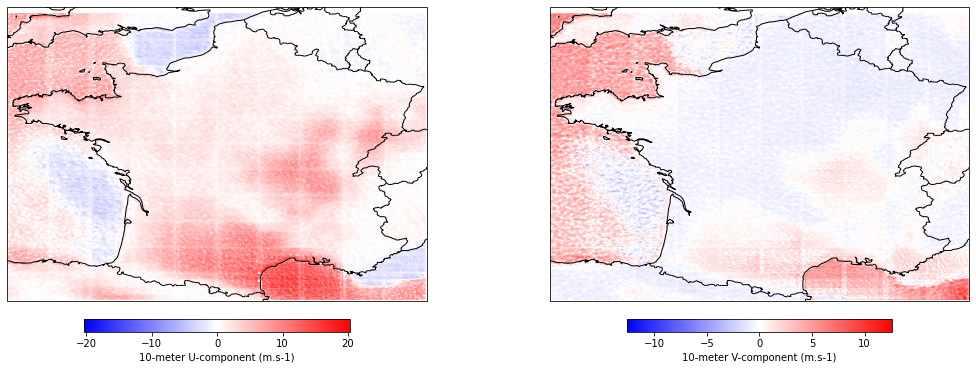

In [12]:
fig = plot_wind_fields(downscaled_maps.isel(time=0), range_lon=LONGITUDE_R, range_lat=LATITUDE_R)
fig.show()

## Downscaling wind fields in Switzerland with target COSMO-1

In [13]:
from downscaling import process_era5, process_topo, predict

In [14]:
ERA5_DATA_FOLDER = DATA_ROOT / 'ERA5'
DEM_DATA_FILE = DATA_ROOT / 'dem/Switzerland-90m-DEM.tif'
START_DATE = date(2016,4,1)
END_DATE = date(2016,4,1)
LONGITUDE_R = (5.8, 10.6)
LATITUDE_R = (45.75, 47.9)

In [15]:
HIGH_RES_TEMPLATE = xr.open_dataset('switzerland_cosmo_map.nc')

In [16]:
era5 = process_era5(xr.open_dataset(ERA5_DATA_FOLDER / '20171005_era5_surface_hourly.nc'), high_res_template=HIGH_RES_TEMPLATE)
topo = process_topo(xr.open_rasterio(DEM_DATA_FILE), high_res_template=HIGH_RES_TEMPLATE)

In [17]:
downscaled_maps = predict(era5, topo, high_res_template=HIGH_RES_TEMPLATE)

Generator: 1,795,666 weights
Discriminator: 3,306,057 weights
Total: 5,101,723 weights


## Plots of wind fields in Switzerland

In [20]:
from downscaling import plot_elevation, plot_wind_fields
from cartopy.crs import epsg
HIGH_RES_CRS = epsg(21781)  # crs for the target map, for plots

<ipython-input-21-df4855868774>:3: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_topo.show()
/Users/Boubou/opt/anaconda3/envs/downscale_dev/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


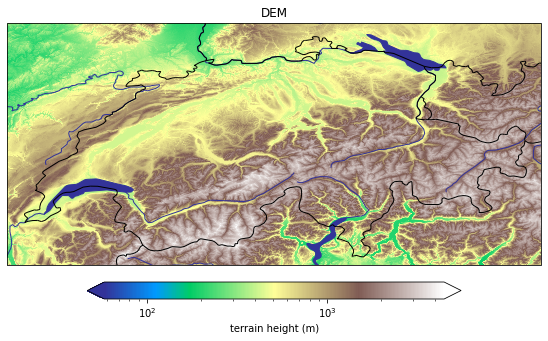

In [21]:
raw_topo = xr.open_rasterio(DEM_DATA_FILE)
fig_topo = plot_elevation(raw_topo, range_lon=LONGITUDE_R, range_lat=LATITUDE_R)
fig_topo.show()

<ipython-input-22-9ed96c542ec8>:2: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


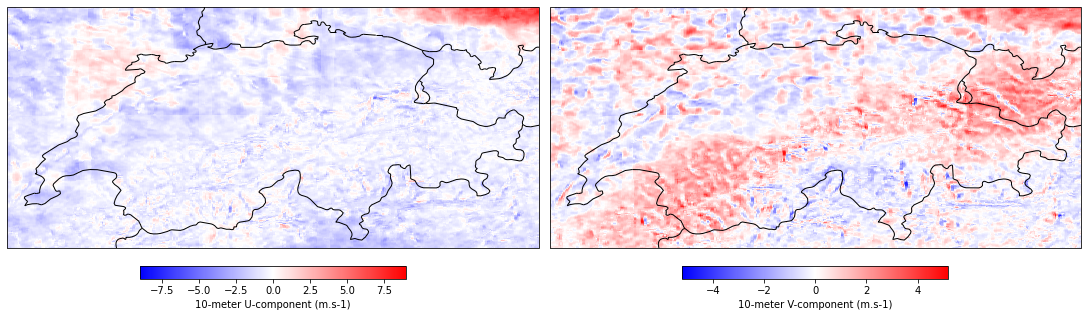

In [22]:
fig = plot_wind_fields(downscaled_maps.isel(time=0), range_lon=LONGITUDE_R, range_lat=LATITUDE_R, high_res_crs=HIGH_RES_CRS)
fig.show()